## Fruit Image Classification
### data source: https://www.kaggle.com/moltean/fruits

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow 
import keras
import h5py
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

#### GOALS: 
1) use neural network to correctly classify the type of fruits in the test set of images
- binary classification easy (can pick just 2 fruits that DO NOT look similar, ie banana and coconut)
- binary classification harder (can pick just 2 fruits that DO look similar (or ARE similar), maybe avocado and ripe avocado)
- may use other machine learning algorithms from Sklearn to use as comparison to Keras model

2) if some sucess is seen here, can try out the dataset that has multiple fruits per image, this will be more difficult and change up the problem

### multiclass classification 
#### four fruits selected for mini dataset

In [2]:
from sklearn.datasets import load_files

In [3]:
def load_dataset(path):
    data=load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels

In [4]:
X_train, y_train, target_labels = load_dataset('fruits-360/Training_mini')

In [5]:
X_test, y_test, _ = load_dataset('fruits-360/Test_mini')

In [6]:
print('Training set:', X_train.shape[0])
print('Test set:', X_test.shape[0])

Training set: 2147
Test set: 719


In [7]:
n_class=len(np.unique(y_train))

In [8]:
from keras.utils import np_utils
y_train=np_utils.to_categorical(y_train, n_class)
y_test=np_utils.to_categorical(y_test, n_class)

In [9]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

In [10]:
def convert_to_array(pics):
    img_arr =[]
    for pic in pics:
        img_arr.append(img_to_array(load_img(pic)))
    return img_arr

In [11]:
X_train = np.array(convert_to_array(X_train))
X_test = np.array(convert_to_array(X_test))

In [12]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [13]:
X_train[0].shape

(100, 100, 3)

In [14]:
print (np.__version__)
print (keras.__version__)

1.17.3
2.3.1


In [15]:
#import all the pieces of the neural network
from keras.models import Sequential, Model#the model
from keras.layers import Dense, Dropout, Activation, Flatten, Input #fully connected layers
from keras.layers import Convolution2D, MaxPooling2D #the convnet
from keras.utils import np_utils #extra tools
from keras.callbacks import ModelCheckpoint

In [16]:
filepath="weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
from keras.callbacks import History #may want to print history if set verbose to 0
history = History()

In [18]:
# load the weights that yielded the best validation accuracy
#model.load_weights('cnn_test.hdf5')

In [19]:
#THE MODEL#
batch_size = 32
nb_classes = n_class
nb_epoch = 2

img_rows =100
img_cols=100
img_channels = 3

model_input=Input(shape=(img_rows, img_cols,img_channels))

x = Convolution2D(32, 3, 3, border_mode='same')(model_input)
x = Activation('relu')(x)
x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
conv_out = Flatten()(x)

x1 = Dense(nb_classes, activation='softmax')(conv_out)
# x2 = Dense(nb_classes, activation='softmax')(conv_out)
# x3 = Dense(nb_classes, activation='softmax')(conv_out)
# x4 = Dense(nb_classes, activation='softmax')(conv_out)
# x5 = Dense(nb_classes, activation='softmax')(conv_out)

lst = [x1]#, x2, x3, x4, x5]

#model = Model(input=model_input, output=lst)
model = Model(input=model_input, output=lst) 

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, callbacks=[history],verbose=1)
#set verbose to 0 if you run many, 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
2147/2147 [==============================] - 16s 7ms/step - loss: 0.1115 - accuracy: 0.9627
Epoch 2/2
2147/2147 [==============================] - 10s 5ms/step - loss: 5.5475e-05 - accuracy: 1.0000


In [20]:
y_pred = model.predict(X_test)

In [21]:
score=model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 1.0


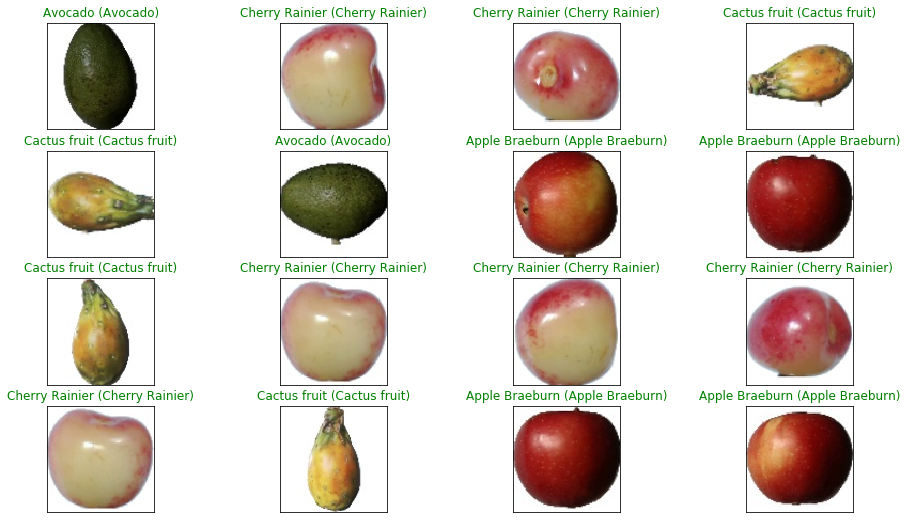

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))